# Use PyMC Model for Bayes Hierarchical RL
- Estimate learning rate (i.e. alpha) for each subject using this model

In [1]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import theano
import theano.tensor as tt
import scipy
import os
# import stan

import pymc3 as pm
import arviz as az
# import learning package
#import DMpy

In [3]:
# read scr file
#scr = pd.read_csv('/media/Data/Lab_Projects/PTSD_Reversal/Behavioral/SCR3.csv')
scr = pd.read_csv('Behavioral/SCR3.csv')
scr.head()


,Event.Nr,CDA.nSCR,CDA.Latency,CDA.AmpSum,CDA.SCR,CDA.ISCR,CDA.PhasicMax,CDA.Tonic,TTP.nSCR,TTP.Latency,TTP.AmpSum,Global.Mean,Global.MaxDeflection,Event.NID,Event.Name,Condition,group,sub
0,1,5,0.8435,0.2852,0.0003,0.1339,8.1296,2.3324,1,3.9335,0.5884,2.4822,0.5884,5,5,CSplusUS1,HC,189
1,2,4,0.7335,0.1033,0.0012,0.4737,0.3046,4.0029,0,NaN,0.0000,4.3933,0.0000,5,5,CSminus1,HC,189
2,3,3,2.9835,0.0783,0.0008,0.3237,0.1352,3.9579,1,2.8335,0.0260,3.9900,0.0154,5,5,CSplus1,HC,189
3,4,1,3.4935,0.1772,0.0002,0.0993,7.0748,3.8756,1,3.5335,0.5186,3.9212,0.5186,5,5,CSplusUS1,HC,189
4,5,0,NaN,0.0000,0.0004,0.1532,0.1604,4.2513,0,NaN,0.0000,4.3461,0.0000,5,5,CSminus1,HC,189


In [4]:
scr = scr[['sub','Condition','Event.Nr','CDA.AmpSum']]
scr['sub'] = scr['sub'].astype('string')
for i in scr.iterrows():
    if len(i[1]['sub'])<=2:
        #print(i[1]['sub'])
        sub = 'sub-0' + str(i[1]['sub'])
    else:
        sub = 'sub-' + str(i[1]['sub'])
    #print(sub)
    scr.at[i[0], 'sub'] = sub
    

In [5]:
len(scr['sub'].unique())

101

In [6]:
# grab subjects with 69 trials
scr_clean = scr.copy() # make a copy of original
for sub in scr['sub'].unique():
    df = scr[scr['sub']==sub]
    #print (len(df))
    if len(df)<69:
        scr_clean = scr_clean[scr_clean['sub']!=sub]
len(scr_clean['sub'].unique()) # total of 86 valid subjects

86

In [7]:
# grab just two subjects for now
scrTwo = scr_clean#[(scr['sub']==152) |(scr['sub']==189) | (scr['sub']==86) | (scr['sub']==48)]
scrTwo['Event.Nr'].values

array([ 1,  2,  3, ..., 67, 68, 69])

Organize the data for the analysis

In [8]:
# organize data accordingly
# first, grab just the relevant variables (subject, trial, stimuli, shock)
# we need to generate a new variable shock (1=yes, 0=no)
# we also need a new variable stim (1=CS+, 2=CS-)
scrVec = scrTwo['CDA.AmpSum'].values
print(scrVec.shape)
shockVec = np.zeros(len(scrVec), dtype=np.int32) # vector to capture shock (1=yes, 0=no)
stimVec = np.zeros(len(scrVec), dtype=np.int32) # vector to capture stimulus (1=CS+, 2= CS-)

for i, cond in enumerate(scrTwo['Condition'].values):
    if cond=='CSplusUS1':
        shockVec[i]= 1
        stimVec[i] = 1
    elif cond=='CSminusUS2':
            # after reversal so minus becomes plus
        shockVec[i]= 1
        stimVec[i] = 0
    elif cond=='CSplus2':
            # after reversal so plus becomes minus
            shockVec[i]=0
            stimVec[i] = 1
    elif cond=='CSplus1':
            stimVec[i] = 1
            shockVec[i]= 0
    elif cond=='CSminus1':
            stimVec[i] = 0
            shockVec[i] = 0
    elif cond=='CSminus2':
        stimVec[i] = 0
        shockVec[i] = 0
    else:
        print(f' Condition is {cond}')
        stimVec[i] = 9
        shockVec[i] = 9
print(shockVec.shape)
print(stimVec.shape)

(5934,)
(5934,)
(5934,)


In [9]:
n_trials, n_subj = 69,len(scrTwo['sub'].unique())
trials, subj = np.meshgrid(range(n_trials), range(n_subj))
trials = tt.as_tensor_variable(trials.T)
subj = tt.as_tensor_variable(subj.T)
stim = np.reshape(stimVec, (n_subj,n_trials)).T # transform to matrix trials x subject
shock = np.reshape(shockVec, (n_subj,n_trials)).T 
scrMat = np.reshape(scrVec, (n_subj, n_trials)).T

In [10]:
stim = tt.as_tensor_variable(stim)
shock = tt.as_tensor_variable(shock)


# Build PyMC code

In [11]:
#scrs = tt.zeros(30) # set empty scr tensor (vector)
   
# generate functions to run
def update_Q(stim, shock,
             Qs,vec,
             alpha, n_subj):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by theano.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the theano.scan fn argument:
        fn=lamba action, reward, Qs, alpha: tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """
      
    PE = shock - Qs[tt.arange(n_subj), stim]
    Qs = tt.set_subtensor(Qs[tt.arange(n_subj),stim], Qs[tt.arange(n_subj),stim] + alpha * PE)
    
    # in order to get a vector of expected outcome (dependent on the stimulus presentes [CS+, CS-] 
    # we us if statement (switch in theano)
    vec = tt.set_subtensor(vec[tt.arange(n_subj),0], (tt.switch(tt.eq(stim,1), 
                                                                Qs[tt.arange(n_subj),1], Qs[tt.arange(n_subj),0])))
    
    return Qs, vec

def theano_llik_td(alpha,  stim, shock, n_subj):
   # stim = theano.shared(np.asarray(stim, dtype='int16'))
   # shock = theano.shared(np.asarray(shock, dtype='int16'))

    # Compute the Qs values
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])

       
    return Qs, vec

In [ ]:
with pm.Model() as m:
  
      
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, 1, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    tr = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

In [ ]:
az.plot_trace(tr, var_names='alpha')

In [ ]:
az.summary(tr, var_names='alpha')

# Add intercept

In [ ]:
# try alpha as beta distribution
with pm.Model() as m2:
  
    intercept = pm.Normal('intercept', 0,.5, shape=n_subj)  
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, .5, shape=n_subj)
    eps = pm.HalfNormal('eps', 1)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = intercept[subj] + vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    
    trI = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

In [ ]:
az.summary(trI)

In [ ]:
az.compare({'model1': tr, 'model2_intercept':trI}) 

# Set intercept as all subjects

In [ ]:
with pm.Model() as m3:
  
    intercept = pm.Normal('intercept', 0,.5)  
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, .5, shape=n_subj)
    eps = pm.HalfNormal('eps', 1)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = intercept + vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    
    tr3 = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

In [ ]:
az.summary(tr3)

In [ ]:
az.compare({'model1': tr, 'model2_intercept':trI, 'model3_jointIntercept':tr3}) 

# Joint Slope

In [ ]:
with pm.Model() as m4:
  
    intercept = pm.Normal('intercept', 0,.5,  shape=n_subj)  
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, .5)
    eps = pm.HalfNormal('eps', 1)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = intercept[subj] + vec[trials, subj,0] * beta
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    
    tr4 = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

In [ ]:
az.summary(tr4)

In [ ]:
az.compare({'model1': tr, 'model2_intercept':trI, 'model3_jointIntercept':tr3,
           'model4_jointBeta':tr4}) 

# Both intercept and slope are joined

In [ ]:
with pm.Model() as m5:
  
    intercept = pm.Normal('intercept', 0,.5)  
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, .5)
    eps = pm.HalfNormal('eps', 1)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = intercept + vec[trials, subj,0] * beta
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    tr5 = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

In [ ]:
az.summary(tr5)

In [ ]:
az.compare({'model1': tr, 'model2_intercept':trI, 'model3_jointIntercept':tr3,
           'model4_jointBeta':tr4, 'model5': tr5}) 

## Use reparametarization on $\alpha$

In [ ]:
with pm.Model() as m_pooled:
    
    intercept = pm.Normal('intercept', 0, 2)
    alpha_mu = pm.Beta('alpha_mu', 1, 1)
    alpha_sd = pm.HalfNormal('alpha_sd',.5)
    alpha_matt = pm.Normal('alpha_matt', mu=0, sd=1, shape=n_subj)
    alpha = pm.Deterministic('alpha', alpha_mu + alpha_sd * alpha_matt)
    beta = pm.Normal('beta',0, 5, shape= n_subj)
    eps = pm.HalfNormal('eps', 5)
  
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = intercept + vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    
    trH_1 = pm.sample(target_accept=.9, chains=4, cores=8, return_inferencedata=True)

In [ ]:
az.summary(trH_1)

In [ ]:
az.compare({'model1': tr, 'model2_intercept':trI, 'model3_jointIntercept':tr3,
           'model4_jointBeta':tr4, 'model5': tr5, 'pooledAlpha':trH_1}) 

# Pooling intercet , slope and alpha

In [ ]:
with pm.Model() as m_pooled2:
    
    intercept_mu = pm.Normal('intercept_mu', 0, 1)
    intercept_sd = pm.HalfNormal('intercept_sd',5)
    intercept_matt = pm.Normal('alpha_matt', mu=0, sd=1, shape=n_subj)
    intercept = pm.Deterministic('intercept',intercept_mu + intercept_sd * intercept_matt)
    
    alpha = pm.Beta('alpha', 1, 1, shape = n_subj)
   
    beta_mu = pm.Normal('beta_mu', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 5)
    beta_matt = pm.Normal('beta_matt', 0,1, shape=n_subj)
    beta = pm.Deterministic('beta', beta_mu + beta_sd*beta_matt)
    eps = pm.HalfNormal('eps', 5)
  
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = intercept[subj] + vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    
    trH_2 = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

In [ ]:
az.compare({'model1': tr, 'model2_intercept':trI, 'model3_jointIntercept':tr3,
           'model4_jointBeta':tr4, 'model5': tr5, 'pooledAlpha':trH_1, 'fully_pooled':trH_2}) 

# Similar to Stan model

In [ ]:
with pm.Model() as m_stan:
    mu = pm.Normal('mu', 0, 1, shape=3)
    sd = pm.HalfNormal('sd',5, shape=3)
     
    intercept_matt = pm.Normal('intercept_matt', mu=0, sd=1, shape=n_subj)
    intercept = pm.Deterministic('intercept',intercept_matt + mu[1]*sd[1] )
    
    
    alpha_h = pm.Beta('alpha_h',1,  1, shape = n_subj)
    alpha = pm.Deterministic('alpha', alpha_h + mu[0]* sd[0])
    
    
    beta_matt = pm.Normal('beta_matt',0, 1, shape=n_subj)
    beta = pm.Deterministic('beta', beta_matt + mu[2]*sd[2])
    
    eps = pm.HalfNormal('eps', 5)
  
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = intercept[subj] + vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    
    trH_Stan = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

# Model using hyperparameter in different way
- For reference:
https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/hierarchical_partial_pooling.html

In [12]:
with pm.Model() as m5:
    
    # α
    phi = pm.Uniform("phi", lower=0.0, upper=1.0)
    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log))
    alpha = pm.Beta("alpha", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=n_subj)
    
    # β
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 5)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
       
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec0 = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec0],
        non_sequences=[alpha, n_subj])
   
     
    vec_ = vec[trials, subj,0] * beta[subj]
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    trH_phi = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta, beta_sd, beta_h, alpha, kappa_log, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 912 seconds.


In [ ]:
az.summary(trH_phi)

In [ ]:
az.compare({'simpleModel':tr, 'hierarchy':trH_phi})

### Same but with intercept

In [ ]:
with pm.Model() as m5_intercept:
    
    # intercept
    mu = pm.Normal('mu', 0, 1)
    sd = pm.HalfNormal('sd',5) 
    intercept_matt = pm.Normal('intercept_matt', mu=0, sd=1, shape=n_subj)
    intercept = pm.Deterministic('intercept',intercept_matt + mu*sd)
    
    # \alpha
    phi = pm.Uniform("phi", lower=0.0, upper=1.0)
    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log))
    alpha = pm.Beta("alpha", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=n_subj)
    
    # \beta
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 5)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
       
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec0 = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec0],
        non_sequences=[alpha, n_subj])
   
     
    vec_ = vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    trH_phi2 = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

In [ ]:
az.summary(trH_phi2)

In [ ]:
comp = az.compare({'model1': trH_phi, 'model2':trH_phi2, 'nonHModel':tr}, ic='loo')
comp

In [ ]:
az.plot_compare(comp, insample_dev=False);

## Take the better model, remove pooling of $\beta$

In [ ]:
with pm.Model() as m5_b:
    
    # α
    phi = pm.Uniform("phi", lower=0.0, upper=1.0)
    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log))
    alpha = pm.Beta("alpha", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=n_subj)
    
    # β
    # beta_h = pm.Normal('beta_h', 0,1)
    # beta_sd = pm.HalfNormal('beta_sd', 5)
    beta = pm.Normal('beta',0, 1, shape=n_subj)
       
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec0 = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec0],
        non_sequences=[alpha, n_subj])
   
     
    vec_ = vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    trH_phiB = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

In [ ]:
az.compare({'model1': trH_phi, 'model2':trH_phi2, 'model3':trH_phiB}, ic='loo')

# Correlate with actual data

In [13]:
# stack all chains
a = trH_phi.posterior.stack(draws=('chain','draw'))
a = a.expected_value
a.shape

(69, 86, 4000)

In [14]:
mean_a = np.mean(a, axis=2)
mean_a.shape

(69, 86)

In [15]:
# calculate 
for i in np.arange(n_subj):
    cor1 = scipy.stats.pearsonr(scrMat[:,i], mean_a[:,i])
    print(cor1)

(-0.33286460006070084, 0.005195763236209987)
(0.5826656123909641, 1.5000846251351352e-07)
(0.9575614076854719, 6.426955973894355e-38)
(0.5442927598048287, 1.3365943392192447e-06)
(0.4141053979479696, 0.0004044132594870383)
(0.7132701424824176, 6.118606230732143e-12)
(0.3872937234141185, 0.0010102777666347977)
(0.1727498037426438, 0.15576817099629878)
(0.5496103570833403, 1.0031723380921498e-06)
(0.4116587330560583, 0.0004410611374825212)
(0.3171545568822146, 0.007924182058421995)
(0.7368376521457707, 5.298944518461537e-13)
(0.6150514438948389, 1.8784423659493987e-08)
(0.22714186357924288, 0.06052813439240643)
(0.42941045270004635, 0.00023150720433479414)
(0.05365737154246632, 0.6614699059407464)
(0.4411559808631015, 0.00014815023623009467)
(0.5671329638525228, 3.759311210044476e-07)
(0.5288806668517048, 2.987954812764173e-06)
(0.7026958582180782, 1.6966938831669493e-11)
(0.608450278257646, 2.9237632104802628e-08)
(0.345092081972994, 0.0036847479498327363)
(0.4570124195652395, 7.8986505

In [16]:
# seems that some subjects are really problematic. 
# should consider removing them from analysis
scr_clean['sub'].unique()
mean_a_vec = np.reshape(mean_a.T, (69*86,1)) # reshape to fit dataframe

In [17]:
len(scr_clean)
scr_clean['expected_value'] = mean_a_vec.values

In [18]:
scr_clean['scr'] = scr_clean['CDA.AmpSum']

# Load brain data
Hippocampus - amygdala coupling

In [19]:
amg_hipp = pd.read_csv('amg_hipp_fc_allTrials.csv')
amg_hipp


,index,subject,trialNo,condition,coupling,amg
0,0,sub-167,1,CSplusUS1,0.761905,-0.665134
1,1,sub-167,2,CSminus1,-0.238095,-0.060757
2,2,sub-167,3,CSplus1,0.095238,0.984678
3,3,sub-167,4,CSplusUS1,0.523810,0.488085
4,4,sub-167,5,CSminus1,-0.428571,0.053875
...,...,...,...,...,...,...
5101,1720,sub-200,65,CSminus2,-0.023810,-0.128837
5102,1721,sub-200,66,CSplus2,-0.500000,-0.126025
5103,1722,sub-200,67,CSminus2,-0.119048,-0.097882
5104,1723,sub-200,68,CSplus2,0.452381,0.117315


In [20]:
dfAll = pd.merge(scr_clean, amg_hipp, right_on=['subject','trialNo'], left_on=['sub','Event.Nr'])
dfAll.head()

,sub,Condition,Event.Nr,CDA.AmpSum,expected_value,scr,index,subject,trialNo,condition,coupling,amg
0,sub-189,CSplusUS1,1,0.2852,0.773505,0.2852,1794,sub-189,1,CSplusUS1,0.309524,0.981121
1,sub-189,CSminus1,2,0.1033,0.771380,0.1033,1795,sub-189,2,CSminus1,-0.571429,-0.027048
2,sub-189,CSplus1,3,0.0783,0.772439,0.0783,1796,sub-189,3,CSplus1,-0.476190,-0.045910
3,sub-189,CSplusUS1,4,0.1772,0.773501,0.1772,1797,sub-189,4,CSplusUS1,0.166667,-0.674150
4,sub-189,CSminus1,5,0.0000,0.770322,0.0000,1798,sub-189,5,CSminus1,0.214286,-0.065602


In [21]:
len(dfAll['sub'].unique())

65

In [22]:
# Statistical analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
glm = smf.mixedlm('expected_value ~ coupling + C(condition) + amg + trialNo', data=dfAll, 
    groups = 'subject', 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

                Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    expected_value
No. Observations:    4485       Method:                REML          
No. Groups:          65         Scale:                 0.1802        
Min. group size:     69         Log-Likelihood:        -2692.2399    
Max. group size:     69         Converged:             Yes           
Mean group size:     69.0                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.428    0.062  6.883 0.000  0.306  0.550
C(condition)[T.CSminus2]    0.243    0.030  8.063 0.000  0.184  0.303
C(condition)[T.CSminusUS2]  0.396    0.031 12.684 0.000  0.335  0.457
C(condition)[T.CSplus1]     0.192    0.022  8.916 0.000  0.150  0.234
C(condition)[T.CSplus2]     0.061   

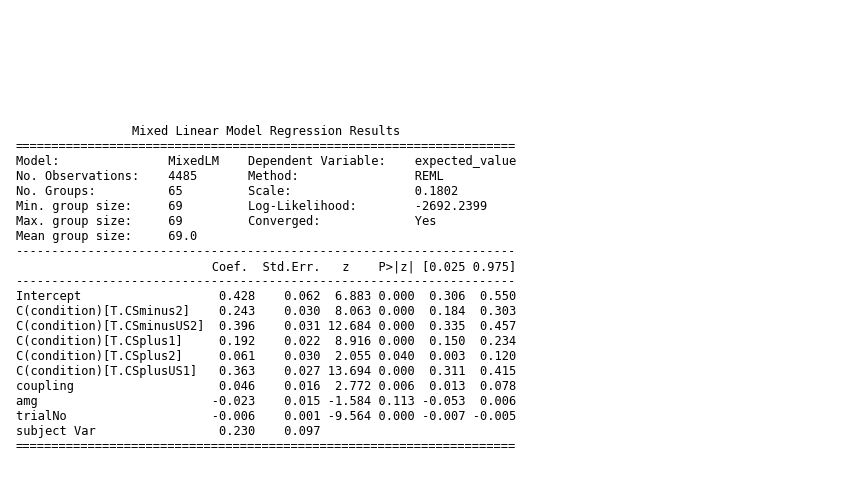

In [23]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model1.summary()), {'fontsize': 12}, fontproperties = 'monospace') 
plt.axis('off')
plt.tight_layout()
plt.savefig('outputEV_Coupling.png')

# Summary:
- Amg-Hippocampus coupling is significantly predicting expected value!

## Look at groups?

In [30]:
dfGroups = pd.read_csv('Behavioral/SubGroupLists.csv', dtype={'Sub': 'string'})
dfGroups = dfGroups[['Sub','group', 'Eprime']]
for i in dfGroups.iterrows():
    dfGroups.at[i[0], 'Sub'] = "sub-" + str(i[1].Sub)


In [32]:
dfAll = pd.merge(dfAll, dfGroups, left_on='subject',right_on='Sub')
dfAll.head()

,sub,Condition,Event.Nr,CDA.AmpSum,expected_value,scr,index,subject,trialNo,condition,coupling,amg,Sub,group,Eprime
0,sub-189,CSplusUS1,1,0.2852,0.773505,0.2852,1794,sub-189,1,CSplusUS1,0.309524,0.981121,sub-189,HC,A
1,sub-189,CSminus1,2,0.1033,0.771380,0.1033,1795,sub-189,2,CSminus1,-0.571429,-0.027048,sub-189,HC,A
2,sub-189,CSplus1,3,0.0783,0.772439,0.0783,1796,sub-189,3,CSplus1,-0.476190,-0.045910,sub-189,HC,A
3,sub-189,CSplusUS1,4,0.1772,0.773501,0.1772,1797,sub-189,4,CSplusUS1,0.166667,-0.674150,sub-189,HC,A
4,sub-189,CSminus1,5,0.0000,0.770322,0.0000,1798,sub-189,5,CSminus1,0.214286,-0.065602,sub-189,HC,A


In [35]:
# Statistical analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
glm2 = smf.mixedlm('expected_value ~ coupling*C(group) + C(condition) + amg + trialNo', data=dfAll, 
    groups = 'subject', 
                 missing='drop')
model2 = glm2.fit()
print(model2.summary())

                Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    expected_value
No. Observations:    4485       Method:                REML          
No. Groups:          65         Scale:                 0.1801        
Min. group size:     69         Log-Likelihood:        -2689.3026    
Max. group size:     69         Converged:             Yes           
Mean group size:     69.0                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.778    0.101  7.738 0.000  0.581  0.975
C(group)[T.VCC]            -0.497    0.131 -3.779 0.000 -0.754 -0.239
C(group)[T.VPTSD]          -0.492    0.137 -3.600 0.000 -0.760 -0.224
C(condition)[T.CSminus2]    0.244    0.030  8.080 0.000  0.185  0.303
C(condition)[T.CSminusUS2]  0.395   

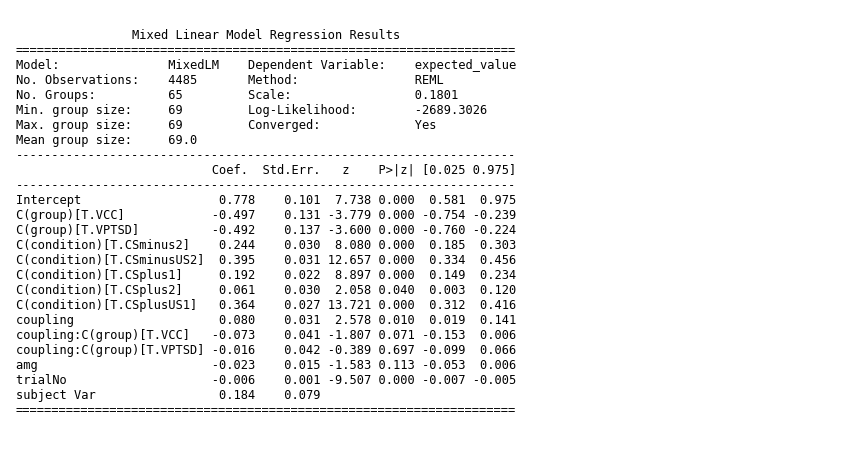

In [38]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model2.summary()), {'fontsize': 12}, fontproperties = 'monospace') 
plt.axis('off')
plt.tight_layout()
plt.savefig('outputEV_Coupling_groups.png')

# Summary
- Coupling predicting changes
- Difference between HC and CC/PTSD
- Maybe because of reversal? 

In [45]:
# Test just first stage of reversal
# first build RL model
scr_1 = scr[scr['Event.Nr']<=30]

scrVec = scr_1['CDA.AmpSum'].values
print(scrVec.shape)
shockVec = np.zeros(len(scrVec), dtype=np.int32) # vector to capture shock (1=yes, 0=no)
stimVec = np.zeros(len(scrVec), dtype=np.int32) # vector to capture stimulus (1=CS+, 2= CS-)

for i, cond in enumerate(scr_1['Condition'].values):
    if cond=='CSplusUS1':
        shockVec[i]= 1
        stimVec[i] = 1
    elif cond=='CSplus1':
            stimVec[i] = 1
            shockVec[i]= 0
    elif cond=='CSminus1':
            stimVec[i] = 0
            shockVec[i] = 0
    else:
        print(f' Condition is {cond}')
        stimVec[i] = 9
        shockVec[i] = 9
print(shockVec.shape)
print(stimVec.shape)


(3030,)
(3030,)
(3030,)


In [47]:
n_trials, n_subj = 30,len(scr_1['sub'].unique())
trials, subj = np.meshgrid(range(n_trials), range(n_subj))
trials = tt.as_tensor_variable(trials.T)
subj = tt.as_tensor_variable(subj.T)
stim = np.reshape(stimVec, (n_subj,n_trials)).T # transform to matrix trials x subject
shock = np.reshape(shockVec, (n_subj,n_trials)).T 
scrMat = np.reshape(scrVec, (n_subj, n_trials)).T

stim = tt.as_tensor_variable(stim)
shock = tt.as_tensor_variable(shock)


In [48]:
# run model
with pm.Model() as m5_1stPart:
    
    # α
    phi = pm.Uniform("phi", lower=0.0, upper=1.0)
    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log))
    alpha = pm.Beta("alpha", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=n_subj)
    
    # β
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 5)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
       
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec0 = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec0],
        non_sequences=[alpha, n_subj])
   
     
    vec_ = vec[trials, subj,0] * beta[subj]
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    tr_firstPart = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta, beta_sd, beta_h, alpha, kappa_log, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 342 seconds.


In [49]:
az.summary(tr_firstPart)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_h,1.680,0.183,1.333,2.026,0.002,0.001,9677.0,2497.0,1.0
beta[0],0.303,0.256,-0.199,0.767,0.003,0.003,8475.0,2957.0,1.0
beta[1],1.732,0.249,1.254,2.191,0.003,0.002,6060.0,3333.0,1.0
beta[2],3.738,0.269,3.226,4.229,0.003,0.002,6026.0,3546.0,1.0
beta[3],2.075,0.265,1.585,2.581,0.003,0.002,7888.0,2766.0,1.0
...,...,...,...,...,...,...,...,...,...
"expected_value[29, 96]",0.032,0.047,-0.003,0.133,0.001,0.001,5132.0,2435.0,1.0
"expected_value[29, 97]",0.077,0.069,0.000,0.202,0.001,0.001,6414.0,2613.0,1.0
"expected_value[29, 98]",0.015,0.033,-0.018,0.095,0.001,0.000,4871.0,3100.0,1.0
"expected_value[29, 99]",0.007,0.017,0.000,0.029,0.000,0.000,6447.0,2567.0,1.0


In [50]:
# stack all chains
b = tr_firstPart.posterior.stack(draws=('chain','draw'))
b = b.expected_value
print(b.shape)

mean_b = np.mean(b, axis=2)
mean_b.shape

(30, 101, 4000)


(30, 101)

In [52]:
# calculate 
for i in np.arange(n_subj):
    cor1 = scipy.stats.pearsonr(scrMat[:,i], mean_b[:,i])
    print(cor1)

(0.6768321853617298, 4.009330522660171e-05)
(0.4231474534927742, 0.019814073456368736)
(0.9423449469450209, 7.704748530534286e-15)
(0.5505725675720514, 0.0016182494541318183)
(0.3867774164960823, 0.03473699138213348)
(0.77858451524778, 4.056588690012224e-07)
(0.4062105741085954, 0.025920688421142625)
(0.3559383525489235, 0.05354830327526823)
(0.6136275596676269, 0.00031077566516669425)
(0.7253535423850037, 5.7654251111423e-06)
(0.47849275634877425, 0.007478700619966696)
(0.5743166596728955, 0.0009037628142868754)
(0.7798980504740507, 3.7654205763118074e-07)
(0.6405579081649269, 0.00013732166998032375)
(0.3550935586894243, 0.054158559783994864)
(0.4155582517153405, 0.022384520039639394)
(0.33534501120034976, 0.07005140548779129)
(0.4151576600639719, 0.022527467643471633)
(0.578128330046804, 0.0008196833530201793)
(0.6215650595204978, 0.0002461974903294659)
(0.8335939375848666, 1.0714899021297713e-08)
(0.6890816899243736, 2.5441701072733235e-05)
(0.7469193545825689, 2.1272332780723264e-0

In [53]:

scr_1['sub'].unique()
mean_b_vec = np.reshape(mean_b.T, (30*len(scr_1['sub'].unique()),1)) # reshape to fit dataframe
len(scr_clean)
scr_1['expected_value'] = mean_b_vec.values
scr_1['scr'] = scr_1['CDA.AmpSum']

/tmp/ipykernel_4575/2305217894.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scr_1['expected_value'] = mean_b_vec.values
/tmp/ipykernel_4575/2305217894.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scr_1['scr'] = scr_1['CDA.AmpSum']


In [58]:
dfAll_1 = pd.merge(scr_1, amg_hipp, right_on=['subject','trialNo'], left_on=['sub','Event.Nr'])
dfAll_1 = pd.merge(dfAll_1, dfGroups, left_on='subject',right_on='Sub')

dfAll_1.head()

,sub,Condition,Event.Nr,CDA.AmpSum,expected_value,scr,index,subject,trialNo,condition,coupling,amg,Sub,group,Eprime
0,sub-189,CSplusUS1,1,0.2852,0.196651,0.2852,1794,sub-189,1,CSplusUS1,0.309524,0.981121,sub-189,HC,A
1,sub-189,CSminus1,2,0.1033,0.106369,0.1033,1795,sub-189,2,CSminus1,-0.571429,-0.027048,sub-189,HC,A
2,sub-189,CSplus1,3,0.0783,0.133744,0.0783,1796,sub-189,3,CSplus1,-0.476190,-0.045910,sub-189,HC,A
3,sub-189,CSplusUS1,4,0.1772,0.187123,0.1772,1797,sub-189,4,CSplusUS1,0.166667,-0.674150,sub-189,HC,A
4,sub-189,CSminus1,5,0.0000,0.078994,0.0000,1798,sub-189,5,CSminus1,0.214286,-0.065602,sub-189,HC,A


In [59]:
glm3 = smf.mixedlm('expected_value ~ coupling*C(group) + C(condition) + amg + trialNo', data=dfAll_1, 
    groups = 'subject', 
                 missing='drop')
model3 = glm3.fit()
print(model3.summary())

                Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    expected_value
No. Observations:     2010       Method:                REML          
No. Groups:           67         Scale:                 0.2153        
Min. group size:      30         Log-Likelihood:        -1454.0359    
Max. group size:      30         Converged:             Yes           
Mean group size:      30.0                                            
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   0.988    0.130   7.585 0.000  0.733  1.243
C(group)[T.VCC]            -0.567    0.169  -3.365 0.001 -0.898 -0.237
C(group)[T.VPTSD]          -0.550    0.175  -3.143 0.002 -0.893 -0.207
C(condition)[T.CSplus1]     0.283    0.023  12.139 0.000  0.237  0.328
C(condition)[T.CSplusUS

In [96]:
forPlot = dfAll_1.groupby(['group','Event.Nr']).mean()
forPlot

CDA.AmpSum  expected_value       scr        index  trialNo  \
group Event.Nr                                                               
HC    1           2.778047        1.989717  2.778047  1114.894737      1.0   
      2           1.519479        1.257478  1.519479  1115.894737      2.0   
      3           1.589632        1.136855  1.589632  1116.894737      3.0   
      4           1.837347        1.912771  1.837347  1117.894737      4.0   
      5           0.696737        0.845123  0.696737  1118.894737      5.0   
...                    ...             ...       ...          ...      ...   
VPTSD 26          0.106818        0.363967  0.106818  1593.181818     26.0   
      27          0.066945        0.055499  0.066945  1594.181818     27.0   
      28          0.134355        0.232579  0.134355  1595.181818     28.0   
      29          0.118709        0.168857  0.118709  1596.181818     29.0   
      30          0.097036        0.049690  0.097036  1597.181818     30.0   

                coupling       amg  
group Event.Nr                      
HC    1         0.235589  0.419645  
      2         0.031328  0.242327  
      3         0.149123  0.011517  
      4         0.097744 -0.024410  
      5         0.005013 -0.280668  
...                  ...       ...  
VPTSD 26       -0.045455 -0.065275  
      27        0.059524  0.086063  
      28        0.147186 -0.032194  
      29        0.160173  0.038585  
      30        0.051948  0.072184  

[90 rows x 7 columns]

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing oth

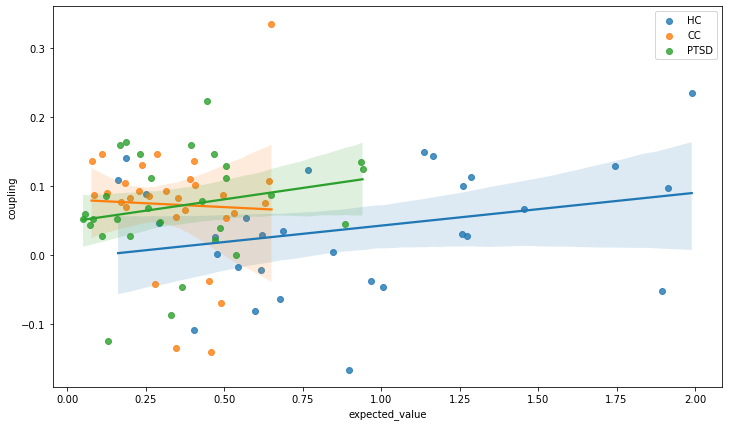

In [97]:
sns.regplot(forPlot['expected_value']['HC'], forPlot['coupling']['HC'], label='HC')
sns.regplot(forPlot['expected_value']['VCC'], forPlot['coupling']['VCC'], label='CC')
sns.regplot(forPlot['expected_value']['VPTSD'], forPlot['coupling']['VPTSD'], label='PTSD')
plt.legend()

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing oth

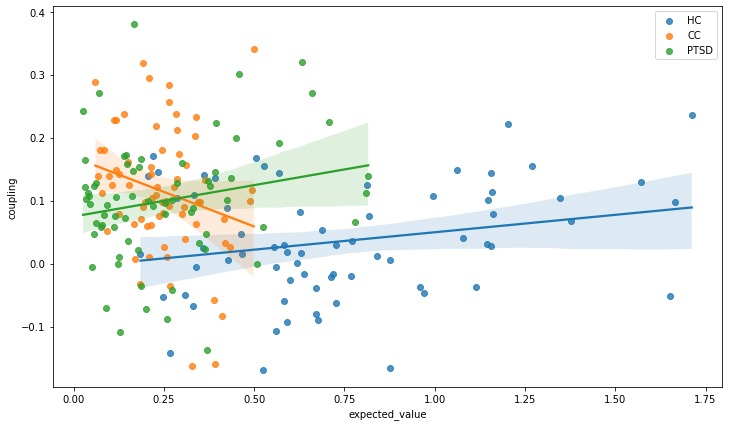

In [98]:
# all experiment
forPlot = dfAll.groupby(['group','Event.Nr']).mean()
sns.regplot(forPlot['expected_value']['HC'], forPlot['coupling']['HC'], label='HC')
sns.regplot(forPlot['expected_value']['VCC'], forPlot['coupling']['VCC'], label='CC')
sns.regplot(forPlot['expected_value']['VPTSD'], forPlot['coupling']['VPTSD'], label='PTSD')
plt.legend()

## Second part (after reversal)

In [107]:
# Test just first stage of reversal
# first build RL model
scr_2 = scr[scr['Event.Nr']>30]
for sub in scr_2['sub'].unique():
    df = scr_2[scr_2['sub']==sub]
    #print(len(df))
    #print (len(df))
    if len(df)<39:
        scr_2 = scr_2[scr_2['sub']!=sub]
len(scr_2['sub'].unique()) # total of 86 valid subjects
scrVec = scr_2['CDA.AmpSum'].values
print(scrVec.shape)
shockVec = np.zeros(len(scrVec), dtype=np.int32) # vector to capture shock (1=yes, 0=no)
stimVec = np.zeros(len(scrVec), dtype=np.int32) # vector to capture stimulus (1=CS+, 2= CS-)

for i, cond in enumerate(scr_2['Condition'].values):
    if cond=='CSminusUS2':
        shockVec[i]= 1
        stimVec[i] = 1
    elif cond=='CSplus2':
            stimVec[i] = 1
            shockVec[i]= 0
    elif cond=='CSminus2':
            stimVec[i] = 0
            shockVec[i] = 0
    else:
        print(f' Condition is {cond}')
        stimVec[i] = 9
        shockVec[i] = 9
print(shockVec.shape)
print(stimVec.shape)


(3354,)
(3354,)
(3354,)


In [108]:
n_trials, n_subj = 39,len(scr_2['sub'].unique())
trials, subj = np.meshgrid(range(n_trials), range(n_subj))
trials = tt.as_tensor_variable(trials.T)
subj = tt.as_tensor_variable(subj.T)
stim = np.reshape(stimVec, (n_subj,n_trials)).T # transform to matrix trials x subject
shock = np.reshape(shockVec, (n_subj,n_trials)).T 
scrMat = np.reshape(scrVec, (n_subj, n_trials)).T

stim = tt.as_tensor_variable(stim)
shock = tt.as_tensor_variable(shock)


In [109]:
# run model
with pm.Model() as m5_2ndPart:
    
    # α
    phi = pm.Uniform("phi", lower=0.0, upper=1.0)
    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log))
    alpha = pm.Beta("alpha", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=n_subj)
    
    # β
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 5)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
       
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec0 = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec0],
        non_sequences=[alpha, n_subj])
   
     
    vec_ = vec[trials, subj,0] * beta[subj]
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    tr_secondPart = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta, beta_sd, beta_h, alpha, kappa_log, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1165 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [110]:
# stack all chains
c = tr_secondPart.posterior.stack(draws=('chain','draw'))
c = c.expected_value
print(c.shape)

mean_c = np.mean(c, axis=2)
mean_c.shape

(39, 86, 4000)


(39, 86)

In [112]:
# calculate 
for i in np.arange(n_subj):
    cor2 = scipy.stats.pearsonr(scrMat[:,i], mean_c[:,i])
    print(cor2)

scr_2['sub'].unique()
mean_c_vec = np.reshape(mean_c.T, (39*len(scr_2['sub'].unique()),1)) # reshape to fit dataframe

scr_2['expected_value'] = mean_c_vec.values
scr_2['scr'] = scr_2['CDA.AmpSum']

(0.1104082350158959, 0.503421317139628)
(0.08042834472986837, 0.626454724038485)
(0.9887207726458529, 4.077179046740726e-32)
(0.41144822202366466, 0.009260569144128166)
(-0.1502305707312255, 0.3613157623197772)
(0.7194022645192121, 2.4667375523551146e-07)
(0.032517710800334367, 0.8442049068108956)
(-0.19626026708089722, 0.23112874841472572)
(0.09966254250822527, 0.5460773443826588)
(0.28549832587960866, 0.07810259765297307)
(-0.31642146163087137, 0.04970290077151094)
(0.4518786524099112, 0.0038790953701914057)
(0.2750330052176877, 0.09016021319044756)
(0.17571553600208148, 0.28462240408398654)
(-0.009794409014626304, 0.9528108545047128)
(0.05396392796360623, 0.7442141204293529)
(-0.2652017429418406, 0.10274996105059864)
(0.18418257589495804, 0.26167862598235786)
(0.050783262798029784, 0.7588272472529242)
(0.0019639648095031367, 0.9905325986499782)
(0.5741037717340104, 0.000132675086335259)
(0.6970768860256591, 8.215714257865665e-07)
(0.26901093285103567, 0.09772190410764835)
(0.0126078

In [113]:
dfAll_2 = pd.merge(scr_2, amg_hipp, right_on=['subject','trialNo'], left_on=['sub','Event.Nr'])
dfAll_2 = pd.merge(dfAll_2, dfGroups, left_on='subject',right_on='Sub')

dfAll_2.head()

,sub,Condition,Event.Nr,CDA.AmpSum,expected_value,scr,index,subject,trialNo,condition,coupling,amg,Sub,group,Eprime
0,sub-189,CSminusUS2,31,0.1891,1.377526,0.1891,1824,sub-189,31,CSminusUS2,0.309524,-0.019869,sub-189,HC,A
1,sub-189,CSplus2,32,0.1990,1.360865,0.1990,1825,sub-189,32,CSplus2,-0.095238,1.367512,sub-189,HC,A
2,sub-189,CSminus2,33,0.0109,1.344925,0.0109,1826,sub-189,33,CSminus2,-0.547619,0.636185,sub-189,HC,A
3,sub-189,CSminusUS2,34,0.1214,1.377174,0.1214,1827,sub-189,34,CSminusUS2,0.476190,0.615788,sub-189,HC,A
4,sub-189,CSplus2,35,2.0312,1.360522,2.0312,1828,sub-189,35,CSplus2,-0.547619,-0.159760,sub-189,HC,A


In [114]:
glm4 = smf.mixedlm('expected_value ~ coupling*C(group) + C(condition) + amg + trialNo', data=dfAll_2, 
    groups = 'subject', 
                 missing='drop')
model4 = glm4.fit()
print(model4.summary())

                Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    expected_value
No. Observations:    2535       Method:                REML          
No. Groups:          65         Scale:                 0.1300        
Min. group size:     39         Log-Likelihood:        -1158.2035    
Max. group size:     39         Converged:             Yes           
Mean group size:     39.0                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.338    0.062  5.418 0.000  0.216  0.461
C(condition)[T.CSminusUS2]  0.175    0.021  8.448 0.000  0.134  0.216
C(condition)[T.CSplus2]     0.019    0.016  1.197 0.231 -0.012  0.050
coupling                    0.034    0.019  1.814 0.070 -0.003  0.072
amg                        -0.026   

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing oth

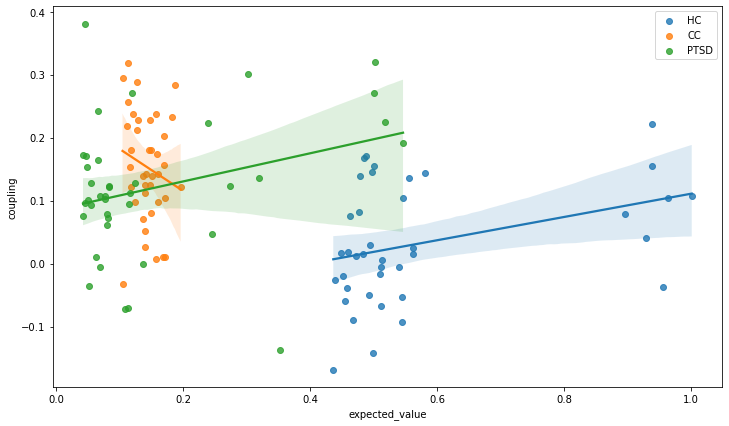

In [116]:
# all experiment
forPlot = dfAll_2.groupby(['group','Event.Nr']).mean()
sns.regplot(forPlot['expected_value']['HC'], forPlot['coupling']['HC'], label='HC')
sns.regplot(forPlot['expected_value']['VCC'], forPlot['coupling']['VCC'], label='CC')
sns.regplot(forPlot['expected_value']['VPTSD'], forPlot['coupling']['VPTSD'], label='PTSD')
plt.legend()